In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
# Generator model
def build_generator():
    model = Sequential([
        Dense(256 * 7 * 7, activation="relu", input_dim=100),
        Reshape((7, 7, 256)),
        BatchNormalization(),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation='relu'),
        BatchNormalization(),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation='relu'),
        BatchNormalization(),
        Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation='tanh')
    ])
    return model

# Discriminator model
def build_discriminator(img_shape):
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=img_shape),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [4]:
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train / 255.0
X_train = np.expand_dims(X_train, axis=-1)

In [5]:
img_shape = (28, 28, 1)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-06-18 18:47:29.892242: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-06-18 18:47:29.892262: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-18 18:47:29.892268: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-18 18:47:29.892284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA

In [6]:
generator = build_generator()
z = tf.keras.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def save_imgs(epoch, generator, examples=25, dim=(5, 5), figsize=(5, 5)):
    noise = np.random.normal(0, 1, (examples, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    #plt.imshow(plt.imread())
    fig.savefig(f"mnist_{epoch}.png")
    plt.close()

In [8]:
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = combined.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_imgs(epoch, generator)

In [9]:
train(epochs=200, batch_size=32)

2024-06-18 18:47:30.144243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6790206432342529, acc.: 72.65625] [G loss: [array(0.6843657, dtype=float32), array(0.6843657, dtype=float32), array(0.484375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

: 

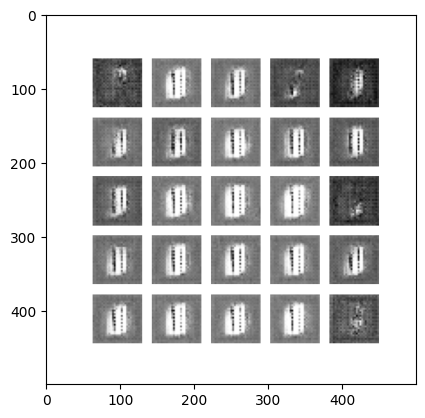

In [ ]:
plt.imshow(plt.imread("mnist_2000.png"))